# Data Exploration

## Downloading the data

Our dataset is from huggingface.co. So we can install it using their library in python itself. 
But below provided are also a set of links to download the data or instructions on the setup environment off the internet

### Link to dataset: [civil_comments](https://huggingface.co/datasets/google/civil_comments)

### Links to setup environment for this project:

- [__Python 3.9__](https://www.python.org/downloads/)
- [__numpy__](https://numpy.org/install/)
- [__matplotlib__](https://matplotlib.org/stable/users/index.html)
- [__seaborn__](https://seaborn.pydata.org/installing.html)
- [__scikit-learn__](https://scikit-learn.org/stable/install.html)
- [__datasets__](https://pypi.org/project/datasets/)

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
import re

In [26]:
from datasets import load_dataset

dataset = load_dataset("google/civil_comments")

In [27]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit'],
        num_rows: 1804874
    })
    validation: Dataset({
        features: ['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit'],
        num_rows: 97320
    })
    test: Dataset({
        features: ['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit'],
        num_rows: 97320
    })
})


In [28]:
print("Number of observations in training data:",len(dataset["train"]),"\n")
print("Number of observations in test data:",len(dataset["test"]),"\n")
print("Number of observations in validation data:", len(dataset["validation"]), "\n")
print("Total number of observations:", len(dataset["train"]) + len(dataset["test"]) + len(dataset["validation"]),"\n")

Number of observations in training data: 1804874 

Number of observations in test data: 97320 

Number of observations in validation data: 97320 

Total number of observations: 1999514 



From the entire dataset, we have a total of __1,999,514__ observations.
We will edit our train dataset however

In [29]:
df_train = dataset["train"].to_pandas()

In [30]:
features = df_train.columns.tolist()

In [31]:
print(features, "\n")

['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit'] 



### There are a total of __8__ features in this dataset.

### text, toxicity, severe_toxicity, obscene, threat, insult, identity_attack, sexual_explicit


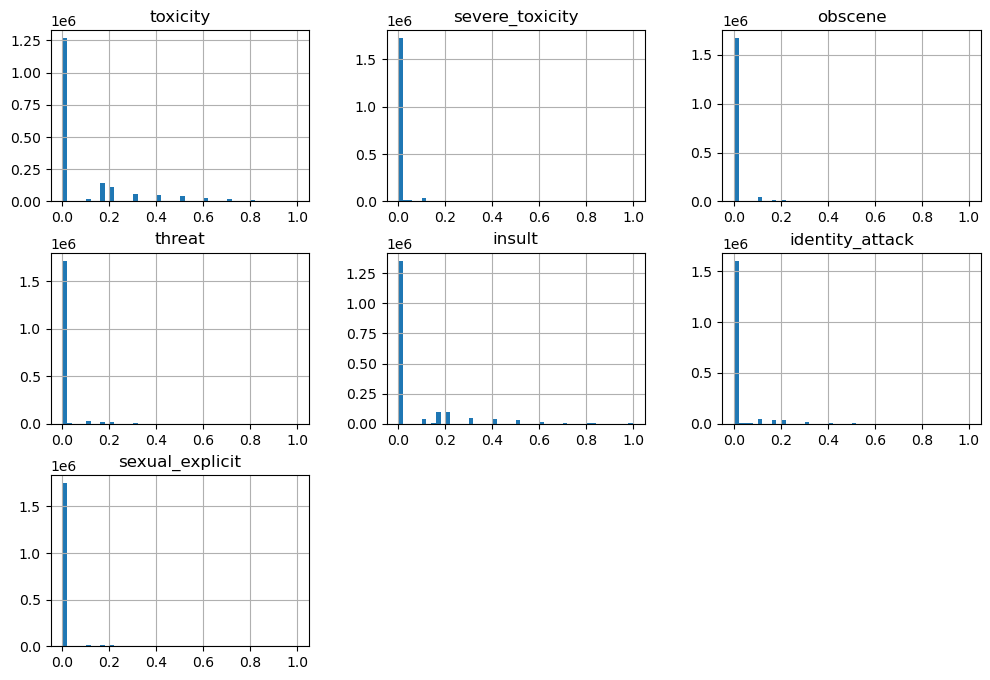

In [32]:
df_train[features].hist(bins=50, figsize=(12,8))
plt.show()

In [33]:
df_train[features].describe()

,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,1.030173e-01,4.582100e-03,1.387721e-02,9.311274e-03,8.115274e-02,2.263572e-02,6.605973e-03
std,1.971960e-01,2.270813e-02,6.410343e-02,4.904731e-02,1.767215e-01,7.920368e-02,4.496850e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [34]:
df_train.dtypes

text                object
toxicity           float32
severe_toxicity    float32
obscene            float32
threat             float32
insult             float32
identity_attack    float32
sexual_explicit    float32
dtype: object

### FEATURE DESCRIPTIONS 

There is a column labeled _text_ which is of type string. This is the statement which is ranked by the 7 features.

The rest of the features are _toxicity_, _severe_toxicity_, _obscene_, _threat_, _insult_, _identity_attack_, _sexual_explicit_

These features are all of float type. From the histogram's x values we can see that all the values are between a range from 0 to 1.

This means that in each column, the features are assigned a percentage of what people believe that text fits in. 

In [35]:
# Count of observations with all labels set to 0
target_columns = ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit'] 
(df_train[target_columns] > 0).sum()

toxicity           540110
severe_toxicity    104636
obscene            147175
threat             106929
insult             454539
identity_attack    218552
sexual_explicit     68926
dtype: int64

As we can see, most entries in this data are non hateful regular comments with everything set to 0. Thus, we will remove most of these when training our model to handle this data imbalance.

#### EXTRACTING NULL FEATURES

In [36]:
df_train[features].isnull().sum()

text               0
toxicity           0
severe_toxicity    0
obscene            0
threat             0
insult             0
identity_attack    0
sexual_explicit    0
dtype: int64

There are no null values 

#### EXTRACTING DUPLICATE ENTRIES

In [37]:
df_train['text'].duplicated().sum()

24051

Number of duplicated observations is 24051. We will drop all these duplicates to avoid future issues. 

In [38]:
df_train = df_train.drop_duplicates(subset=['text'])

In [39]:
df_train['text'].duplicated().sum()

0

Now the number of duplicated observations is 0

### DATA PLOTS

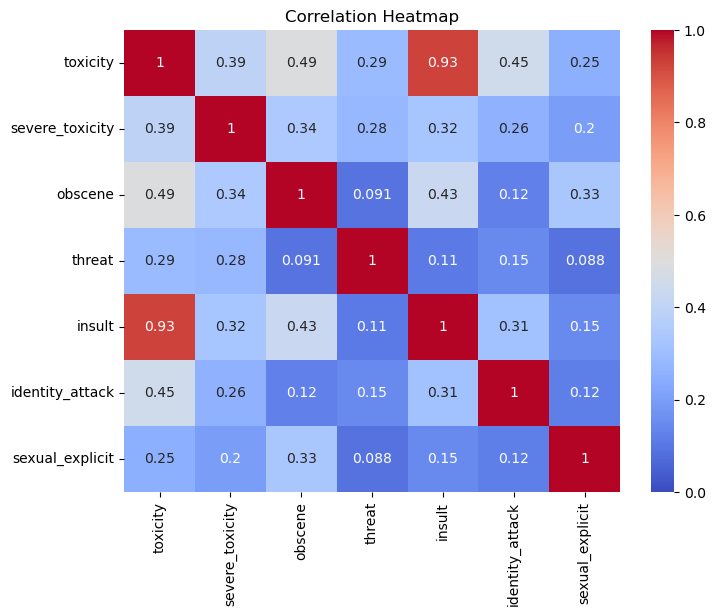

In [40]:
df_train_heatmap = df_train.copy()
df_train_heatmap = df_train_heatmap.drop(columns = ["text"])
plt.figure(figsize=(8,6))
corr = df_train_heatmap.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin = 0, vmax = 1)
plt.title("Correlation Heatmap")
plt.show()

This correlation heatmap tells us that toxicity and insult have a strong correlation. The sexual explicit has the least correlations with the features. This tells us that sexual explicit would not be a good feature to train with. 

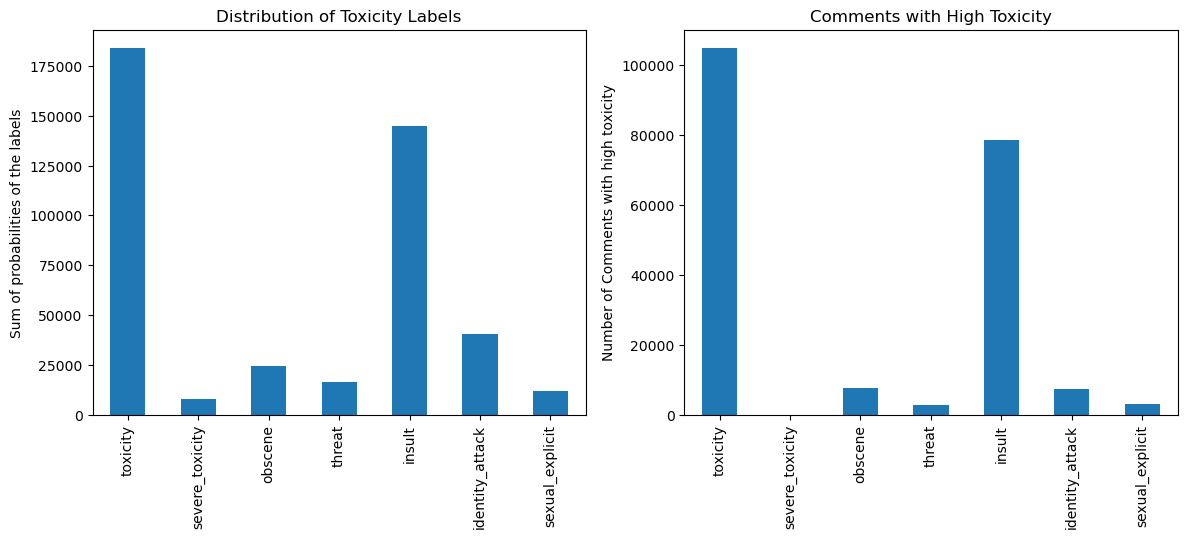

In [41]:

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
# Sum of the total probabilities of the labels
df_train[target_columns].sum().plot(kind='bar', ax=ax[0])
ax[0].set_ylabel("Sum of probabilities of the labels")
ax[0].set_title("Distribution of Toxicity Labels")

# Number of comments above 0.5 for each label
(df_train[target_columns] > 0.5).sum().plot(kind='bar', ax=ax[1])
ax[1].set_ylabel("Number of Comments with high toxicity")
ax[1].set_title("Comments with High Toxicity")

plt.show()

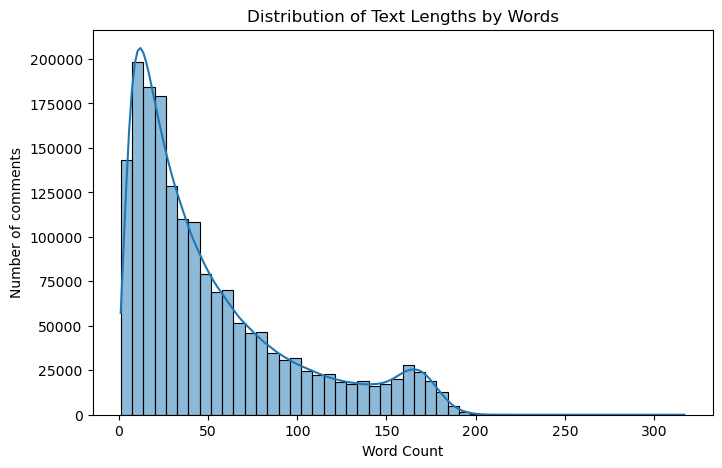

In [42]:
df_train['text_length'] = df_train['text'].str.split().str.len()
plt.figure(figsize = (8,5))
sns.histplot(df_train['text_length'], bins=50, kde = True)
plt.title("Distribution of Text Lengths by Words")
plt.xlabel("Word Count")
plt.ylabel("Number of comments")
plt.show()

In [43]:
print("Mean Word Count is : ", df_train['text_length'].mean(), "\n")
print("Standard Deviation is : ", df_train['text_length'].std())

Mean Word Count is :  51.690132595996346 

Standard Deviation is :  46.14809789802869


In [44]:
# Finding the most common word count
counts, bin_edges = np.histogram(df_train['text_length'], bins=50)

# Find the index of the maximum count
max_idx = np.argmax(counts)

# Compute the corresponding x-value (center of the bin)
x_max = (bin_edges[max_idx] + bin_edges[max_idx + 1]) / 2
print('Most common word count is:', x_max)

Most common word count is: 10.48


This histogram describes the word distribution in the dataset. From this plot, we can see that the comments range from 1 word to 317 words with the mean being ~52 and standard deviation being ~46. 
Most of the comments(~20,000) are around 10-25 words

1. Preprocessing and Feature Engineering

First, we will perform the necessary preprocessing steps to prepare the data for the Naive Bayes model. This includes:
1.  **Creating a Binary Target**: We will create a single toxic column (1 for toxic, 0 for non-toxic). A comment is considered toxic if any of its toxicity scores are > 0.5.
2.  **Balancing the Dataset**: To address the severe class imbalance, we will create a balanced dataset of 100,000 comments (50,000 toxic, 50,000 non-toxic).
3.  **Text Cleaning**: We will convert text to lowercase, remove special characters, and normalize whitespace.
4.  **Feature Engineering**: We will use TF-IDF for text vectorization and create additional numerical features like text length and word count.
5.  **Train-Validation Split**: The balanced data will be split into training and validation sets.

In [101]:
# --- Create a Binary Target and a Balanced Dataset ---
target_columns = ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']
df_train['toxic'] = (df_train[target_columns] > 0.5).any(axis=1).astype(int)

toxic_comments = df_train[df_train['toxic'] == 1]
non_toxic_comments = df_train[df_train['toxic'] == 0]

# Create a balanced dataset
non_toxic_sampled = non_toxic_comments.sample(n=50000, random_state=42)
toxic_sampled = toxic_comments.sample(n=50000, random_state=42)
df_balanced = pd.concat([toxic_sampled, non_toxic_sampled])

print("Balanced dataset created with:")
print(f"- {len(toxic_sampled)} toxic comments")
print(f"- {len(non_toxic_sampled)} non-toxic comments\n")

Balanced dataset created with:
- 50000 toxic comments
- 50000 non-toxic comments



In [102]:
# --- Text Preprocessing ---
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_balanced['cleaned_text'] = df_balanced['text'].apply(clean_text)
df_balanced.dropna(subset=['cleaned_text'], inplace=True)

# --- Train-Validation Split ---
X = df_balanced.drop('toxic', axis=1)
y = df_balanced['toxic']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- Feature Engineering and Vectorization ---
# TF-IDF for text
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=5, max_df=0.8, stop_words='english')
X_train_text = tfidf.fit_transform(X_train['cleaned_text'])
X_val_text = tfidf.transform(X_val['cleaned_text'])

print("Feature matrix created with shape:", X_train_text.shape)


Feature matrix created with shape: (80000, 5000)



We will now train a MultinomialNB model, as it is well-suited for text classification tasks with TF-IDF features. We will evaluate its performance on both the training and validation sets.

In [ ]:
# --- Model Training: Naive Bayes ---
nb_model = MultinomialNB(alpha=0.1)
nb_model.fit(X_train_text, y_train)

# --- Predictions ---
y_train_pred = nb_model.predict(X_train_text)
y_val_pred = nb_model.predict(X_val_text)

# --- Evaluation ---
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
train_f1 = f1_score(y_train, y_train_pred)
val_f1 = f1_score(y_val, y_val_pred)

print("--- Naive Bayes Model Performance ---")
print(f"Training Accuracy: {train_acc:.4f}, F1-Score: {train_f1:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}, F1-Score: {val_f1:.4f}\n")
print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))

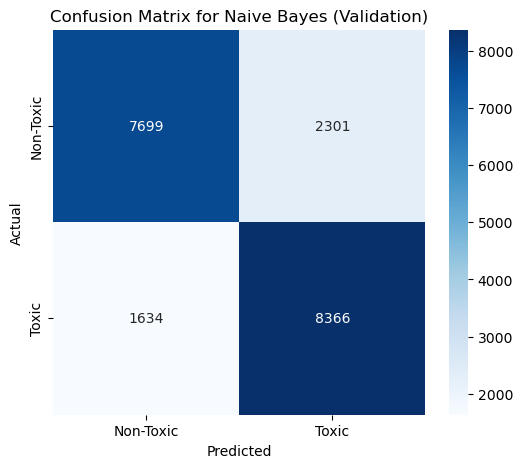

In [103]:
# --- Confusion Matrix ---
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Toxic', 'Toxic'], yticklabels=['Non-Toxic', 'Toxic'])
plt.title('Confusion Matrix for Naive Bayes (Validation)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

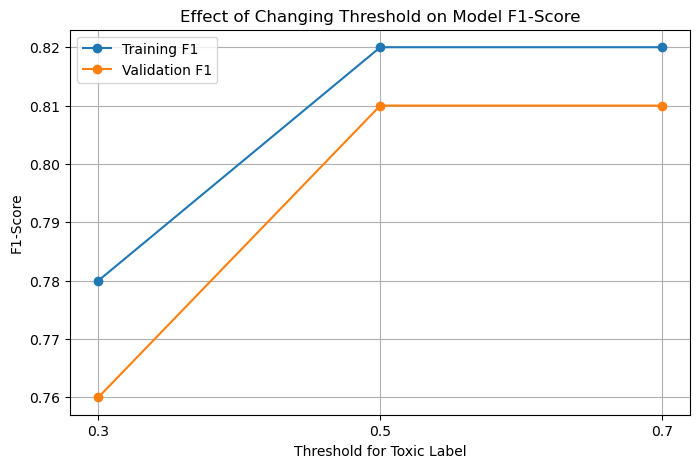

In [104]:
import matplotlib.pyplot as plt

# Thresholds tested
thresholds = [0.3, 0.5, 0.7]

# Corresponding F1-scores (training and validation)
train_f1_scores = [0.78, 0.82, 0.82]
val_f1_scores = [0.76, 0.81, 0.81]

plt.figure(figsize=(8,5))
plt.plot(thresholds, train_f1_scores, marker='o', label='Training F1')
plt.plot(thresholds, val_f1_scores, marker='o', label='Validation F1')
plt.xticks(thresholds)
plt.xlabel('Threshold for Toxic Label')
plt.ylabel('F1-Score')
plt.title('Effect of Changing Threshold on Model F1-Score')
plt.legend()
plt.grid(True)
plt.show()


Where our model fits is based on our classification report. Our training data had a accuracy of __82%__ and f1 score of __82%__. In our testing dataset, we had an accuracy of __80%__ and f1 score of __81%__. Since the difference between the two sets is not large, there is no indications of overfitting. Thus our model is __well-fitted__.  

Our hyperparameter is the _laplace smoothing_ labeled as alpha in our MultinomialNB model . Adjusting the alpha did not really change the fitting graph. Changing the threshold for our labels to a smaller number does. 
Changing the threshold to __0.3__ gave worse results. Training accuracy was __77%__ and f1 score was __78%__. Testing accuracy was __73%__ and f1 score was __76%__.  
Changing the threshold to __0.7__ gave the same results as __0.5__. Training accuracy was __82%__ and f1 score was __82%__. Testing accuracy was __80%__ and f1 score was __81%__.  
Thus there are not many hyperparameters to tune to maximize the fitting. We may need to consider using different models such as __SVM__ or __Decision Trees__ and compare the results.

To conclude, our toxic classifcation model performed relatively well given the dataset. Our training and testing data both had accuracy and f1 score of above 80%. Changing the hyperparameters did not improve our 1st model. In order to improve our model furthermore, we may consider SVMs or Decision Trees. 